#   EDA
## 1. Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_countries = pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2')[2]
df_countries = df_countries[['Code', 'Country name (using title case)']]
df_countries.rename(columns={'Code':'Country','Country name (using title case)':'Country name'},inplace=True)
df_countries.to_csv ('../Data/countries.csv', index = False, header=True)
df_countries = pd.read_csv('../data/countries.csv')
print(df_countries.info())


df_2020Q1 = pd.read_csv('D:/Data Camp/Data/2020Q1.csv', skiprows = 4)
df_2020Q2 = pd.read_csv('D:/Data Camp/Data/2020Q2.csv', skiprows = 4)
df_2020Q3 = pd.read_csv('D:/Data Camp/Data/2020Q3.csv', skiprows = 4)
df_2020Q4 = pd.read_csv('D:/Data Camp/Data/2020Q4.csv', skiprows = 4)

df_2020 = pd.concat([df_2020Q1, df_2020Q2, df_2020Q3, df_2020Q4])


df_2019Q1 = pd.read_csv('D:/Data Camp/Data/2019Q1.csv', skiprows = 4)
df_2019Q2 = pd.read_csv('D:/Data Camp/Data/2019Q2.csv', skiprows = 4)
df_2019Q3 = pd.read_csv('D:/Data Camp/Data/2019Q3.csv', skiprows = 4)
df_2019Q4 = pd.read_csv('D:/Data Camp/Data/2019Q4.csv', skiprows = 4)
df_2019 = pd.concat([df_2019Q1, df_2019Q2, df_2019Q3, df_2019Q4])


df_all = pd.concat([df_2020, df_2019])

df_all['Date'] = pd.to_datetime(df_all['Date'])


df = pd.merge(df_all,df_countries, on='Country')
df = df[['Date', 'City', 'Specie', 'max', 'min', 'median', 'Country name']]
df.info()
df.head()

df_lockdown_dates = pd.read_csv('D:/Data Camp/Data/country_lockdown_dates.csv', engine='python')
df_lockdown_datesJHUMatch = pd.read_csv('D:/Data Camp/Data/countryLockdowndatesJHUMatch.csv', engine='python')
df_lockdown_dates_full = pd.concat([df_lockdown_dates, df_lockdown_datesJHUMatch])
df_lockdown_dates_full['Date'] = pd.to_datetime(df_lockdown_dates_full['Date'])

df_lockdown_dates_full.rename(columns={'Country/Region':'Country name'},inplace=True)
df_lockdown_dates_full = df_lockdown_dates_full[['Country name','Date']]
df_lockdown_dates_full.rename(columns={'Date':'Starting Date'},inplace=True)
df_lockdown_dates_full.tail()
df_final = pd.merge(df, df_lockdown_dates_full, on='Country name')
df_final.head()

df_pm25 = df_final[df_final['Specie'] == 'pm25']
df_pm25 = df_pm25.set_index("Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       248 non-null    object
 1   Country name  249 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4495514 entries, 0 to 4495513
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   City          object        
 2   Specie        object        
 3   max           float64       
 4   min           float64       
 5   median        float64       
 6   Country name  object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 274.4+ MB


In [2]:
def shutdownData(df, country, shutdown_date, reopen_date):

    mask = ((pd.Series(map(lambda x: x.month <= shutdown_date[0], df.index.date), index=df.index)) &
                                                ((pd.Series(map(lambda x: x.day < shutdown_date[1], df.index.date), index=df.index))))
    #first get dates after the start date for all years
    shutdown_time_period_df = df.loc[~mask, :]

    #remove the later months
    shutdown_time_period_df = shutdown_time_period_df.loc[shutdown_time_period_df.index.month<=reopen_date[0]]

    #now get dates before the end date
    mask2 = ((pd.Series(map(lambda x: x.month == reopen_date[0], shutdown_time_period_df.index.date), index=shutdown_time_period_df.index)) &
                                                ((pd.Series(map(lambda x: x.day >= reopen_date[1], shutdown_time_period_df.index.date), index=shutdown_time_period_df.index))))

    shutdown_time_period_df = shutdown_time_period_df.loc[~mask2, :]

    shutdown_time_period_df = shutdown_time_period_df.loc[shutdown_time_period_df["Country name"] == country]
    
    return shutdown_time_period_df

In [10]:
india_pm25_shutdown_df = shutdownData(df_pm25, "India", (3, 24), (8, 18))
india_pm25_shutdown_df

,City,Specie,max,min,median,Country name,Starting Date
Date,,,,,,,
2020-03-27,Thrissur,pm25,213.0,13.0,13.0,India,2020-03-24
2020-04-01,Thrissur,pm25,151.0,13.0,70.0,India,2020-03-24
2020-03-26,Thrissur,pm25,168.0,13.0,30.0,India,2020-03-24
2020-01-31,Thrissur,pm25,52.0,13.0,18.0,India,2020-03-24
2020-02-29,Thrissur,pm25,106.0,13.0,25.0,India,2020-03-24
...,...,...,...,...,...,...,...
2019-08-10,Kolkata,pm25,192.0,25.0,88.0,India,2020-03-24
2019-07-24,Kolkata,pm25,101.0,5.0,51.0,India,2020-03-24
2019-08-12,Kolkata,pm25,174.0,21.0,95.0,India,2020-03-24


In [15]:
bar_plot_info = india_pm25_shutdown_df .groupby(india_pm25_shutdown_df.index.year).mean()
bar_plot_info

,max,min,median
Date,,,
2019,192.453115,53.021639,105.901311
2020,198.286900,32.010561,80.829771


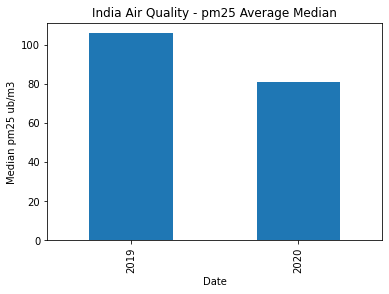

In [16]:
bar_plot_info.plot(kind="bar", y="median", legend=None)
plt.ylabel("Median pm25 ub/m3")
plt.title("India Air Quality - pm25 Average Median")
plt.savefig("D:/Data Camp/Data/Mumbai/India_pm25median.png")

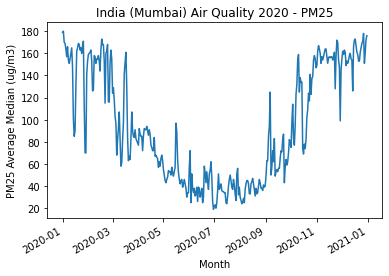

In [19]:
IN_2020_pm25_df = df_pm25.loc[(df_pm25.index.year == 2020) & (df_pm25["City"] == "Mumbai")]
IN_line_axes = IN_2020_pm25_df.plot(kind="line", y="median", legend=None)
#set titles, axes labels
IN_line_axes.set_title("India (Mumbai) Air Quality 2020 - PM25")
IN_line_axes.set_ylabel("PM25 Average Median (ug/m3)")
IN_line_axes.set_xlabel("Month")

IN_line_axes.get_figure().savefig("D:/Data Camp/Data/Mumbai/IN_PM25_2020_line_plot.png")